<a href="https://colab.research.google.com/github/Ramyrahmeni/DeepLearning/blob/main/LSTM-RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Temperature forcasting

In [ ]:
import requests
import zipfile
import io

url = "https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip"

response = requests.get(url)
if response.status_code == 200:
    print("Download successful!")

    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        z.extractall()  # Extract files to the current directory
        print("Unzipped successfully!")
else:
    print(f"Failed to download. Status code: {response.status_code}")


Download successful!
Unzipped successfully!


In [ ]:
with open('jena_climate_2009_2016.csv', 'r') as f:
    data = f.read()

lines = data.split('\n')
header = lines[0].split(',')  # Extract the header (column names)
lines = lines[1:]  # Remove the header from the data

print("Header:", header)
print("Number of data lines:", len(lines) - 1 if lines[-1] == '' else len(lines))  # Handle possible trailing newline


Header: ['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
Number of data lines: 420451


In [ ]:
import numpy as np
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [ ]:
# Assuming float_data is the raw time series data (normalized version)
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std


In [ ]:
len(float_data)

420451

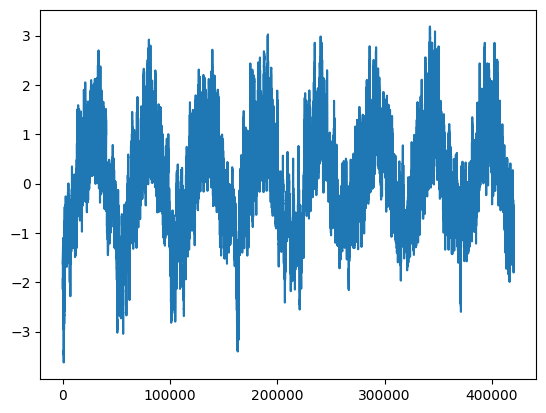

In [ ]:
from matplotlib import pyplot as plt
temp = float_data[:, 1]#Temperature
plt.plot(range(len(temp)), temp)

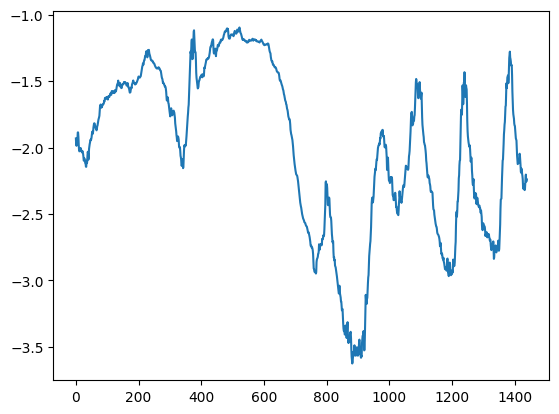

In [ ]:
#first ten days
plt.plot(range(1440), temp[:1440])

In [ ]:
import numpy as np

def create_numpy_arrays(data, lookback, delay, min_index, max_index,
                        shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback

    # Prepare lists for samples and targets
    samples = []
    targets = []

    while i < max_index:
        if shuffle:
            # Randomly sample indices
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                break  # Stop if we can't fill a batch
            rows = np.arange(i, min(i + batch_size, max_index))

        for j in range(len(rows)):
            indices = range(rows[j] - lookback, rows[j], step)
            samples.append(data[indices])
            targets.append(data[rows[j] + delay][1])

        i += len(rows)

    # Convert lists to NumPy arrays
    samples = np.array(samples)
    targets = np.array(targets)

    return samples, targets

# Parameters
lookback = 1440
step = 6
delay = 144
batch_size = 128

# Creating datasets
train_samples, train_targets = create_numpy_arrays(float_data,
                                                    lookback=lookback,
                                                    delay=delay,
                                                    min_index=0,
                                                    max_index=200000,
                                                    shuffle=True,
                                                    step=step,
                                                    batch_size=batch_size)

val_samples, val_targets = create_numpy_arrays(float_data,
                                                lookback=lookback,
                                                delay=delay,
                                                min_index=200001,
                                                max_index=300000,
                                                step=step,
                                                batch_size=batch_size)

test_samples, test_targets = create_numpy_arrays(float_data,
                                                 lookback=lookback,
                                                 delay=delay,
                                                 min_index=300001,
                                                 max_index=None,
                                                 step=step,
                                                 batch_size=batch_size)




In [ ]:
test_samples.shape[0]+train_samples.shape[0]+val_samples.shape[0]

415872

In [ ]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

## Basic ML Approach

In [ ]:
import tensorflow as tf

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='rmsprop', loss='mae')


/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:

# Define callbacks
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    tf.keras.callbacks.EarlyStopping(patience=3)
]

# Train the model
history = model.fit(train_samples, train_targets, validation_data=(val_samples, val_targets), epochs=20)


Epoch 1/20


I0000 00:00:1729697853.711921     107 service.cc:145] XLA service 0x79ea94005430 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729697853.711973     107 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729697853.711977     107 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 109/6208 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 3.0512  

I0000 00:00:1729697854.638694     107 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6208/6208 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.7856 - val_loss: 0.3173
Epoch 2/20
6208/6208 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.2347 - val_loss: 0.3439
Epoch 3/20
6208/6208 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.2145 - val_loss: 0.3275
Epoch 4/20
6208/6208 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.2020 - val_loss: 0.3397
Epoch 5/20
6208/6208 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.1943 - val_loss: 0.3476
Epoch 6/20
6208/6208 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.1872 - val_loss: 0.3727
Epoch 7/20
6208/6208 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.1823 - val_loss: 0.3447
Epoch 8/20
6208/6208 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.1781 - val_loss: 0.3686
Epoch 9/20
6208/6208 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.1738 - val_loss: 0.3425
Epoch 10/20
6208/6208 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.1708 - val_loss: 0.3457
Epoch 11/20
6208/6208 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.1683 - val_loss: 0.3418
Epoch 12/20
6208/6208 ━━━━━━━━

In [ ]:
model.history

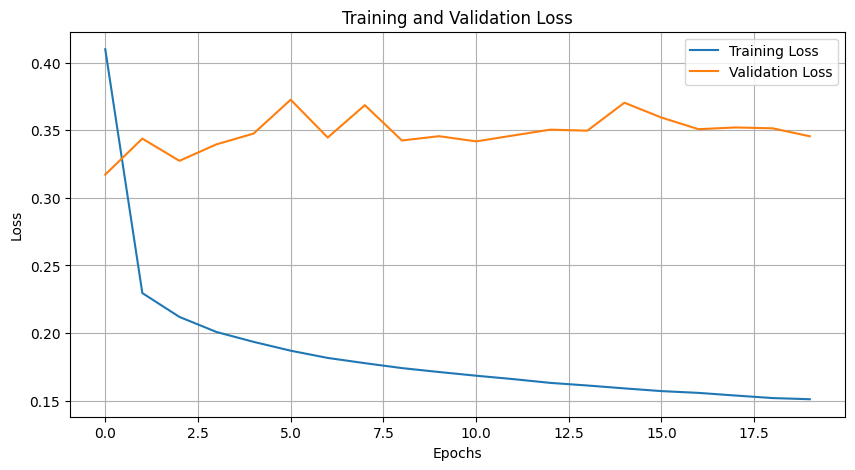

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a plot
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## A first reccurent baseline

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer='rmsprop', loss='mae')
history = model.fit(train_samples, train_targets, validation_data=(val_samples, val_targets), epochs=5)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
6208/6208 ━━━━━━━━━━━━━━━━━━━━ 61s 10ms/step - loss: 0.2932 - val_loss: 0.2686
Epoch 2/5
6208/6208 ━━━━━━━━━━━━━━━━━━━━ 58s 9ms/step - loss: 0.2561 - val_loss: 0.2725
Epoch 3/5
6208/6208 ━━━━━━━━━━━━━━━━━━━━ 58s 9ms/step - loss: 0.2271 - val_loss: 0.2931
Epoch 4/5
6208/6208 ━━━━━━━━━━━━━━━━━━━━ 58s 9ms/step - loss: 0.2056 - val_loss: 0.3042
Epoch 5/5
6208/6208 ━━━━━━━━━━━━━━━━━━━━ 58s 9ms/step - loss: 0.1913 - val_loss: 0.3149


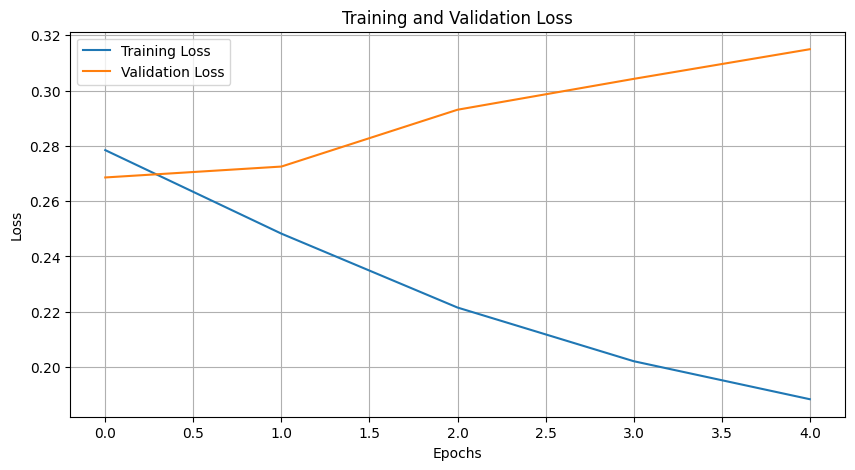

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a plot
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Training and evaluating a dropout-regularized GRU-based model

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.GRU(32,
dropout=0.2,
recurrent_dropout=0.2,
input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')

In [ ]:
history = model.fit(train_samples, train_targets, validation_data=(val_samples, val_targets), epochs=5)

Epoch 1/5
 159/6208 ━━━━━━━━━━━━━━━━━━━━ 17:09 170ms/step - loss: 232745360239437545472.0000

KeyboardInterrupt: 